In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


In [23]:
#Define the Neural Network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(2, activation=None)  #Output layer : x(t),y(t)
    def call(self,t):
        t=self.dense1(t)
        t=self.dense2(t)
        return self.dense3(t)


In [26]:
def loss_fn(model,t):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        tape1.watch(t)
        tape2.watch(t)
        output=model(t)
        x=output[:,0:1]
        y=output[:,1:2]
        dx_dt=tape1.gradient(x,t)
        dy_dt=tape2.gradient(y,t)
     #Residual loss from ODE
        res_x=dx_dt + 2*x + y
        res_y=dy_dt + x + 2*y
     #Initial condition loss
        init_loss_x=tf.square(x[0]-1)
        init_loss_y=tf.square(y[0]-0)
     #Total loss
        loss=tf.reduce_mean(tf.square(res_x))+tf.reduce_mean(tf.square(res_y))+init_loss_x+init_loss_y
    return loss

In [27]:
#Define training steps
def train(model,t,epochs,optimizer):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss=loss_fn(model,t)
        grads=tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
        if epoch%500==0:
            print(f'Epoch {epoch}:Loss={loss.numpy()}')

In [28]:
model=PINN()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

In [29]:
t=tf.convert_to_tensor(np.linspace(0,5,100)[:,None],dtype=tf.float32)

In [30]:
#Training the model
train(model,t,epochs=4000,optimizer=optimizer)

Epoch 0:Loss=[2.7415106]
Epoch 500:Loss=[0.00394806]
Epoch 1000:Loss=[0.00036939]
Epoch 1500:Loss=[0.00090172]
Epoch 2000:Loss=[0.00015022]
Epoch 2500:Loss=[0.00010829]
Epoch 3000:Loss=[7.984396e-05]
Epoch 3500:Loss=[5.736646e-05]


In [31]:
#Predicting using the prediction model
t_test=np.linspace(0,5,100)[:,None]
x_pred,y_pred=model(t_test).numpy().T

In [32]:
#Analytical Solution
x_true=0.5*np.exp(-t_test)+0.5*np.exp(-3*t_test)
y_true=-0.5*np.exp(-t_test)+0.5*np.exp(-3*t_test)

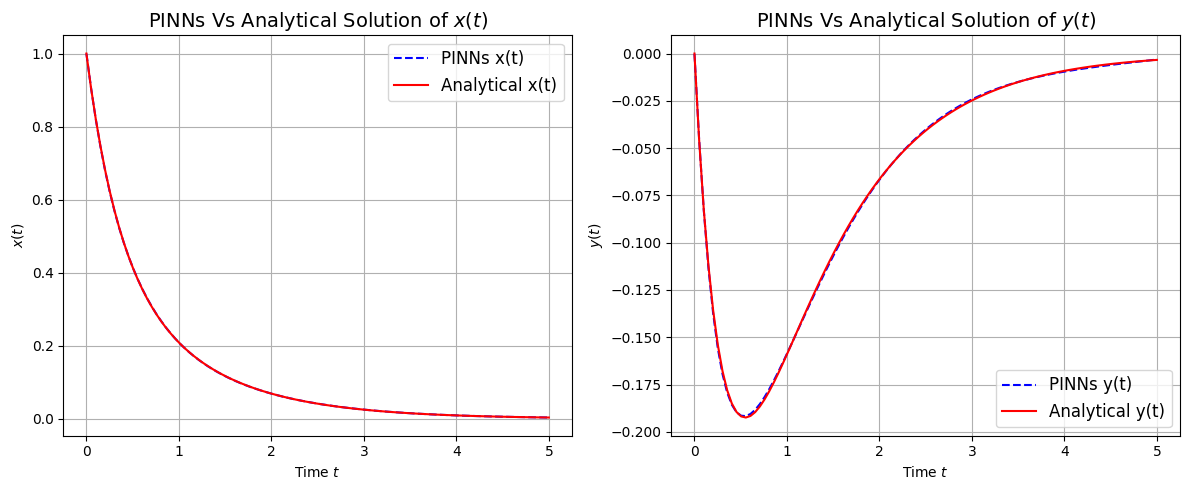

In [36]:
plt.figure(figsize=(12,5))

#Plot x(t)
plt.subplot(1,2,1)
plt.plot(t_test,x_pred,'--',label='PINNs x(t)',color='blue')
plt.plot(t_test,x_true,label='Analytical x(t)',color='red')
plt.title(r'PINNs Vs Analytical Solution of $x(t)$',fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12,loc='upper right')

#Plot y(t)
plt.subplot(1,2,2)
plt.plot(t_test,y_pred,'--',label='PINNs y(t)',color='blue')
plt.plot(t_test,y_true,label='Analytical y(t)',color='red')
plt.title(r'PINNs Vs Analytical Solution of $y(t)$',fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.show()

